In [1086]:
import time 
import json
import requests
from selenium import webdriver
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts import * #导入所有图表
from pyecharts import options as opts
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [1087]:
china_url = 'https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5'
# china_page为腾讯新闻网页数据，无治愈信息
china_page = 'https://news.qq.com/zt2020/page/feiyan.htm#/?nojump=1'
# global_url为数据页面各国病例更新很多不及时，后面将使用webdriver直接爬取global_page(网页)数据
global_url = 'https://view.inews.qq.com/g2/getOnsInfo?name=disease_foreign'
global_page = "https://news.qq.com/zt2020/page/feiyan.htm#/global"

In [1088]:
def fetch_data(url):
    reponse = requests.get(url=url).json()
    data = json.loads(reponse['data'])
    return data

## 国内数据

In [1089]:
data = fetch_data(china_url)
data.keys()

dict_keys(['lastUpdateTime', 'chinaTotal', 'chinaAdd', 'isShowAdd', 'showAddSwitch', 'areaTree'])

In [1090]:
# 数据集包括["国内总量","国内新增","更新时间","数据明细","每日数据","每日新增"]
lastUpdateTime = data['lastUpdateTime']
chinaTotal = data['chinaTotal']
chinaAdd = data['chinaAdd']
lastUpdateTime

'2021-02-04 19:35:01'

In [1091]:
# China summary statistics table
print('Last Updated:',lastUpdateTime)

china_sum = pd.DataFrame(index=['confirm','heal','dead','nowConfirm','localConfirm','importedCase','noInfect'],
                         columns=['total','addToday'])

for i in china_sum.index.values:
    china_sum['total'][i] = chinaTotal[i]
    china_sum['addToday'][i] = chinaAdd[i]
china_sum

Last Updated: 2021-02-04 19:35:01


,total,addToday
confirm,101167,24
heal,94173,58
dead,4830,1
nowConfirm,2164,-35
localConfirm,1104,-3
importedCase,4758,0
noInfect,788,12


In [1155]:
china_sum.to_csv('Covid19-datasets/ChinaSummary%s.csv' %lastUpdateTime)

In [1092]:
print('Last Updated:',lastUpdateTime)

areaTree = data['areaTree']

china_df = areaTree[0]['children']
china_list = []

for a in range(len(china_df)):
    province = china_df[a]['name']
    province_list = china_df[a]['children']
    for b in range(len(province_list)):
        city = province_list[b]['name']
        total = province_list[b]['total']
        today = province_list[b]['today']
        china_dict = {}
        china_dict['province'] = province
        china_dict['city'] = city
        china_dict['total'] = total
        china_dict['today'] = today
        china_list.append(china_dict)
        
china_df = pd.DataFrame(china_list)
china_df.head()

Last Updated: 2021-02-04 19:35:01


,province,city,total,today
0,香港,地区待确认,"{'nowConfirm': 683, 'confirm': 10552, 'suspect...","{'confirm': 0, 'confirmCuts': 0, 'isUpdated': ..."
1,黑龙江,绥化,"{'nowConfirm': 375, 'confirm': 530, 'suspect':...","{'confirm': 0, 'confirmCuts': 0, 'isUpdated': ..."
2,黑龙江,哈尔滨,"{'nowConfirm': 144, 'confirm': 408, 'suspect':...","{'confirm': 0, 'confirmCuts': 0, 'isUpdated': ..."
3,黑龙江,大庆,"{'nowConfirm': 2, 'confirm': 29, 'suspect': 0,...","{'confirm': 0, 'confirmCuts': 0, 'isUpdated': ..."
4,黑龙江,齐齐哈尔,"{'nowConfirm': 1, 'confirm': 44, 'suspect': 0,...","{'confirm': 0, 'confirmCuts': 0, 'isUpdated': ..."


In [1093]:
# 定义数据处理函数
def nowConfirm(x):
    return eval(str(x))['nowConfirm']
def confirm(x):
    confirm = eval(str(x))['confirm']
    return confirm
def dead(x):
    return eval(str(x))['dead']
def heal(x):
    return  eval(str(x))['heal']
def deadRate(x):
    return eval(str(x))['deadRate']
def healRate(x):
    return eval(str(x))['healRate']

# 函数映射
china_df['nowConfirm'] = china_df['total'].map(nowConfirm)
china_df['confirm'] = china_df['total'].map(confirm)
china_df['dead'] = china_df['total'].map(dead)
china_df['heal'] = china_df['total'].map(heal)
china_df['deadRate'] = china_df['total'].map(deadRate)
china_df['healRate'] = china_df['total'].map(healRate)
china_df['addConfirm'] = china_df['today'].map(confirm)
china_df = china_df[['province','city','nowConfirm','confirm','dead','heal','deadRate','healRate','addConfirm']]
china_df

,province,city,nowConfirm,confirm,dead,heal,deadRate,healRate,addConfirm
0,香港,地区待确认,683,10552,185,9684,1.75,91.77,0
1,黑龙江,绥化,375,530,4,151,0.75,28.49,0
2,黑龙江,哈尔滨,144,408,4,260,0.98,63.73,0
3,黑龙江,大庆,2,29,1,26,3.45,89.66,0
4,黑龙江,齐齐哈尔,1,44,1,42,2.27,95.45,0
...,...,...,...,...,...,...,...,...,...
458,海南,陵水县,0,4,0,4,0.00,100.00,0
459,海南,乐东,0,2,0,2,0.00,100.00,0
460,海南,文昌,0,3,0,3,0.00,100.00,0
461,海南,定安县,0,3,1,2,33.33,66.67,0


In [1163]:
china_df.to_csv('Covid19-datasets/ProvinceDeatail%s.csv' %lastUpdateTime,encoding='utf_8_sig',index=False)

In [1094]:
# province aggregate data
china_df_agg = china_df.groupby(['province']).sum()
china_df_agg['deadRate'] = round(china_df_agg['dead']/china_df_agg['confirm'] * 100,2)
china_df_agg['healRate'] = round(china_df_agg['heal']/china_df_agg['confirm'] *100,2)
china_df_agg

,nowConfirm,confirm,dead,heal,addConfirm,deadRate,healRate
province,,,,,,,
上海,125,1714,7,1582,0,0.41,92.30
云南,1,231,2,228,0,0.87,98.70
内蒙古,12,366,1,353,0,0.27,96.45
北京,57,1044,9,978,0,0.86,93.68
台湾,71,919,9,839,0,0.98,91.29
吉林,327,571,3,241,0,0.53,42.21
四川,13,873,3,857,0,0.34,98.17
天津,18,344,3,323,0,0.87,93.90
宁夏,0,75,0,75,0,0.00,100.00


In [1164]:
china_df_agg.to_csv('Covid19-datasets/Province%s.csv' %lastUpdateTime,encoding='utf_8_sig')

In [1095]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--headless')

executable_path = '/Users/kristallqiu/Downloads/chromedriver'

dr = webdriver.Chrome(options = chrome_options, executable_path = executable_path)
dr.get(china_page)

In [1096]:
main_view = dr.find_element_by_id('app')
table = main_view.find_element_by_xpath("//div[2]/div[3]/div[2]/div/table")
tableList = table.text

In [1097]:
# 只能爬取到展开前的数据，未展开的数据无法爬取
data_list = [i.split() for i in tableList.split('\n')]
chinaCaseNow = pd.DataFrame(data_list[1:],columns=data_list[0])
chinaCaseNow.columns = ['city/area','province','addConfirm','nowConfirm','riskLevel']
chinaCaseNow['addConfirm'] = chinaCaseNow['addConfirm'].astype(int)
chinaCaseNow['nowConfirm'] = chinaCaseNow['nowConfirm'].astype(int)
chinaCaseNow

,city/area,province,addConfirm,nowConfirm,riskLevel
0,通化,吉林,0,221,部分中高风险
1,哈尔滨,黑龙江,0,144,部分中高风险
2,长春,吉林,0,102,部分中风险
3,石家庄,河北,0,214,部分中高风险
4,绥化,黑龙江,0,375,部分中高风险
5,黄浦,上海,0,16,部分中风险
6,宝山,上海,0,4,部分中风险


In [1165]:
chinaCaseNow.to_csv('Covid19-datasets/ChinaCase31Day%s.csv' %lastUpdateTime,encoding='utf_8_sig',index=False)

## 国外数据

In [1098]:
# use webdriver to directly scrape the lastest data (real-time)
dr.get(global_page)
main_view = dr.find_element_by_id('app')
summaryTable = main_view.find_element_by_xpath("//div/div[@class='globalWraper']/div[3]\
                                         /div[@class='foreignListWraper']/div[@class='topdataWrap filterGray']\
                                         /div[@class='recentNumber add']")
summaryList = summaryTable.text.split('\n')

countryTable = main_view.find_element_by_xpath("//div/div[@class='globalWraper']/div[3]\
                                        /div[@class='foreignListWraper']/div[@class='listWraper filterGray']\
                                        /table")
countryList = countryTable.text
glastUpdateTime = main_view.find_element_by_xpath('//*[@id="foreignList"]/div[1]/div[1]/p/span').text

In [1099]:
glastUpdateTime

'2021-02-05 02:00:20'

In [1100]:
summaryList

['较上日+28674',
 '27800196',
 '现有确诊',
 '较上日+46266',
 '105018072',
 '累计确诊',
 '较上日+16293',
 '74940161',
 '累计治愈',
 '较上日+1299',
 '2277715',
 '累计死亡']

In [1101]:
print('Last Updated:',glastUpdateTime)
global_sum = pd.DataFrame(columns=['total','addToday'],index=['nowConfrim','confirm','heal','dead'])
for i in range(len(global_sum.columns)):
    global_sum[global_sum.columns[i]] = summaryList[(1-i)::3]
global_sum['addToday'] = global_sum['addToday'].str[3:].astype(int)
for i in list(global_sum.columns):
    global_sum[i] =global_sum[i].astype(int)
global_sum

Last Updated: 2021-02-05 02:00:20


,total,addToday
nowConfrim,27800196,28674
confirm,105018072,46266
heal,74940161,16293
dead,2277715,1299


In [1159]:
global_sum.to_csv('Covid19-datasets/GlobalSummary%s.csv'%glastUpdateTime)

In [1102]:
print('Last Updated:',glastUpdateTime)
gdata1 = countryList.split('\n')
country = gdata1[2::2]
number = gdata1[3::2]
results = [[country[i]] + number[i].split() for i in range(len(country))]
global_df = pd.DataFrame(results,columns=(['nation','addConfirm','confirm','heal','dead']))
global_df = global_df[['nation','confirm','dead','heal','addConfirm']]
for i in list(global_df.columns)[1:]:
    global_df[i] =global_df[i].astype(int)
global_df['deadRate'] = round(global_df['dead']/global_df['confirm'] * 100,2).astype(float)
global_df['healRate'] = round(global_df['heal']/global_df['confirm'] *100,2).astype(float)
global_df      

Last Updated: 2021-02-05 02:00:20


,nation,confirm,dead,heal,addConfirm,deadRate,healRate
0,美国,27157522,462075,16909844,6992,1.70,62.27
1,印度,10790183,154703,10480455,12899,1.43,97.13
2,巴西,9339420,227563,8313044,56002,2.44,89.01
3,英国,3903706,110462,10010,20734,2.83,0.26
4,俄罗斯,3874830,74005,3352720,16463,1.91,86.53
...,...,...,...,...,...,...,...
180,马提尼克岛,37,1,0,5,2.70,0.00
181,梵蒂冈,27,0,15,0,0.00,55.56
182,所罗门群岛,17,0,10,0,0.00,58.82
183,马绍尔群岛,4,0,4,0,0.00,100.00


In [1103]:
world_name = pd.read_excel("世界各国中英文对照.xlsx")
global_df = pd.merge(global_df,world_name,left_on='nation',right_on='Chinese',how="left")
global_df = global_df.rename(columns={'English':'english'})
global_df = global_df[['nation','english','confirm','dead','heal','addConfirm','deadRate','healRate']]
global_df

,nation,english,confirm,dead,heal,addConfirm,deadRate,healRate
0,美国,United States,27157522,462075,16909844,6992,1.70,62.27
1,印度,India,10790183,154703,10480455,12899,1.43,97.13
2,巴西,Brazil,9339420,227563,8313044,56002,2.44,89.01
3,英国,United Kingdom,3903706,110462,10010,20734,2.83,0.26
4,俄罗斯,Russia,3874830,74005,3352720,16463,1.91,86.53
...,...,...,...,...,...,...,...,...
180,马提尼克岛,Martinique,37,1,0,5,2.70,0.00
181,梵蒂冈,Vatican City,27,0,15,0,0.00,55.56
182,所罗门群岛,Solomon Islands,17,0,10,0,0.00,58.82
183,马绍尔群岛,Marshall Islands,4,0,4,0,0.00,100.00


In [ ]:
global_df.to_csv('Covid19-datasets/Foreign%s.csv'%glastUpdateTime,encoding='utf_8_sig',index=False)

In [1104]:
# for plotting the map
chinaInsert = pd.DataFrame(['中国','China'] + [china_sum['total']['confirm']] +[china_sum['total']['dead']] + \
[china_sum['total']['heal']]+ [china_sum['addToday']['confirm']] +\
[round(china_sum['total']['dead']/china_sum['total']['confirm']*100,2)] +\
[round(china_sum['total']['heal']/china_sum['total']['confirm']*100,2)]).transpose()
chinaInsert.columns = global_df.columns.values

global_china_df = global_df.append(chinaInsert).reset_index(drop=True)
global_china_df

,nation,english,confirm,dead,heal,addConfirm,deadRate,healRate
0,美国,United States,27157522,462075,16909844,6992,1.7,62.27
1,印度,India,10790183,154703,10480455,12899,1.43,97.13
2,巴西,Brazil,9339420,227563,8313044,56002,2.44,89.01
3,英国,United Kingdom,3903706,110462,10010,20734,2.83,0.26
4,俄罗斯,Russia,3874830,74005,3352720,16463,1.91,86.53
...,...,...,...,...,...,...,...,...
181,梵蒂冈,Vatican City,27,0,15,0,0,55.56
182,所罗门群岛,Solomon Islands,17,0,10,0,0,58.82
183,马绍尔群岛,Marshall Islands,4,0,4,0,0,100
184,瓦努阿图,Vanuatu,1,0,1,0,0,100


In [1167]:
global_china_df.to_csv('Covid19-datasets/Global%s.csv'%glastUpdateTime,encoding='utf_8_sig',index=False)

In [1105]:
addConfirmRank = global_df.sort_values(['addConfirm'],ascending=False)
addConfirmRank.head(10)

,nation,english,confirm,dead,heal,addConfirm,deadRate,healRate
2,巴西,Brazil,9339420,227563,8313044,56002,2.44,89.01
6,西班牙,Spain,2913389,60370,196958,31596,2.07,6.76
5,法国,France,3310051,77741,234678,26355,2.35,7.09
3,英国,United Kingdom,3903706,110462,10010,20734,2.83,0.26
22,葡萄牙,Portugal,748858,13482,573934,16997,1.80,76.64
4,俄罗斯,Russia,3874830,74005,3352720,16463,1.91,86.53
7,意大利,Italy,2583790,89820,2059248,13182,3.48,79.70
1,印度,India,10790183,154703,10480455,12899,1.43,97.13
12,墨西哥,Mexico,1886245,161240,1450237,12153,8.55,76.88
18,印度尼西亚,Indonesia,1123105,31001,917306,11434,2.76,81.68


In [1169]:
addConfirmRank.to_csv('Covid19-datasets/AddConfirmRank%s.csv'%glastUpdateTime,encoding='utf_8_sig',index=False)

In [1106]:
# use global_url(data page) to get historical daily data
gdata2 = fetch_data(global_url)
gdata2.keys()

dict_keys(['foreignList', 'globalStatis', 'globalDailyHistory', 'importStatis', 'countryAddConfirmRankList', 'countryConfirmWeekCompareRankList', 'continentStatis'])

In [1107]:
print('Last Updated:',gdata2['globalStatis']['lastUpdateTime'])
daily = gdata['globalDailyHistory']
globalDaily = pd.DataFrame(columns=['date']+list(daily[0]['all'].keys()))
globalDaily['date'] = [daily[i]['y']+'-'+daily[i]['date'].replace('.','-') for i in range(len(daily))]
for c in globalDaily.columns.values[1:]:
    globalDaily[c] = [daily[i]['all'][c] for i in range(len(daily))]
globalDaily['deadRate'] = globalDaily['deadRate'].astype(float)
globalDaily['healRate'] = globalDaily['healRate'].astype(float)
globalDaily    

Last Updated: 2021-02-05 00:01:25


,date,confirm,dead,heal,newAddConfirm,deadRate,healRate
0,2020-11-04,12013036,331827,6808872,436038,2.76,56.68
1,2020-11-05,12146905,334638,6864721,529224,2.75,56.51
2,2020-11-06,12274169,336130,6913174,581635,2.74,56.32
3,2020-11-07,12435749,337754,6963910,555829,2.72,56.00
4,2020-11-08,12559981,338781,7014446,441665,2.70,55.85
...,...,...,...,...,...,...,...
85,2021-01-28,32293471,608558,16689802,561903,1.88,51.68
86,2021-01-29,32484223,613325,16817172,570895,1.89,51.77
87,2021-01-30,32695927,617528,16946617,500893,1.89,51.83
88,2021-01-31,32839474,620450,17075995,501824,1.89,52.00


In [1171]:
globalDaily.to_csv('Covid19-datasets/GlobalDaily%s.csv'%glastUpdateTime,encoding='utf_8_sig',index=False)

## 数据分析及可视化

### 国内数据

In [1108]:
oldkey = ['confirm','suspect','dead','heal']
newkey = ['累计确诊','疑似病例','死亡','治愈']
chinaTotal1 = {newkey[i]: chinaTotal[oldkey[i]] for i in range(len(oldkey))}

total_pie = Pie(init_opts=opts.InitOpts(width = '500px',height ='350px'))  #设置主题，和画布大小

total_pie.add("",[list(z) for z in zip(chinaTotal1.keys(), chinaTotal1.values())],
            center=["50%", "50%"], #图的位置
            radius=[50, 80])   #内外径大小
total_pie.set_global_opts(
            title_opts=opts.TitleOpts(title="全国总量",subtitle=("截止"+lastUpdateTime+' GMT+8')))
total_pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{c}"))  #标签格式
total_pie.render_notebook()

In [1109]:
chinaAdd1 = {newkey[i]: chinaAdd[oldkey[i]] for i in range(len(oldkey))}
totaladd_pie = Pie(init_opts=opts.InitOpts(width = '500px',height ='350px'))
totaladd_pie.add("",[list(z) for z in zip(chinaAdd1.keys(), chinaAdd1.values())],
            center=["50%", "50%"],
            radius=[50, 80])
totaladd_pie.set_global_opts(
            title_opts=opts.TitleOpts(title="今日新增",subtitle=("截至"+lastUpdateTime+' GMT+8')))
totaladd_pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{c}"))
totaladd_pie.render_notebook()

In [1133]:
china_df_agg.describe()

,nowConfirm,confirm,dead,heal,addConfirm,deadRate,healRate
count,34.000000,34.000000,34.000000,34.000000,34.0,34.000000,34.000000
mean,63.647059,2975.500000,142.058824,2769.794118,0.0,0.827941,94.213824
std,149.186660,11651.151318,772.784103,10877.000937,0.0,1.232813,10.866663
min,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,42.210000
25%,0.250000,246.000000,1.000000,231.250000,0.0,0.202500,94.170000
50%,10.500000,644.500000,3.000000,635.500000,0.0,0.530000,97.670000
75%,21.750000,1041.000000,7.000000,1009.750000,0.0,0.870000,98.895000
max,683.000000,68150.000000,4512.000000,63637.000000,0.0,6.620000,100.000000


In [1139]:
area_data = china_df_agg.reset_index()[['province','nowConfirm']]
area_map = Map(init_opts=opts.InitOpts(width ='800px',height='550px'))
area_map.add("",[list(z) for z in zip(list(area_data["province"]), list(area_data["nowConfirm"]))],
             "china",is_map_symbol_show=False)
area_map.set_global_opts(title_opts=opts.TitleOpts(title="中国现有确诊病例地图",subtitle=("截止"+lastUpdateTime+' GMT+8')),
                         visualmap_opts=opts.VisualMapOpts(is_piecewise=True,
                pieces = [
                        {"min": 300 , "label": '>300',"color": "#780c0c"},
                        {"min": 200 , "max":300, 'label': '200-300',"color": "#d02828"},
                        {"min": 100, "max": 199, "label": '100-199',"color": "#ff585e"},
                        {"min": 51, "max": 99, "label": '51-99',"color": "#fb8146"},
                        {"min": 10, "max": 50, "label": '10-50',"color": "#ffb248"},
                        {"min": 0, "max": 9, "label": '0-9',"color" : "#fff2d1" }]))
area_map.render_notebook()

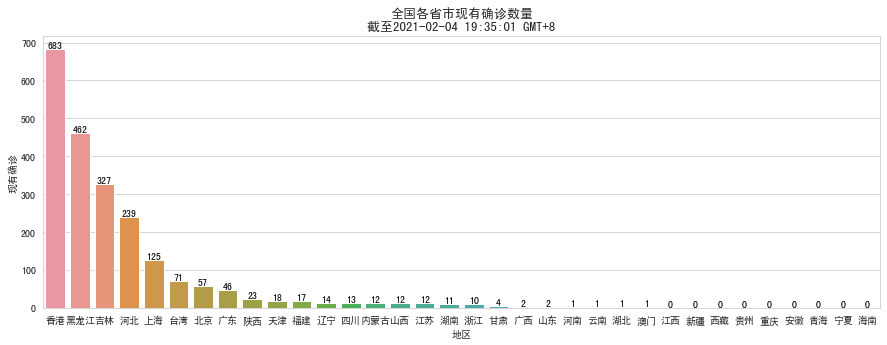

In [1111]:
sort_china1 = china_df_agg.sort_values(['nowConfirm'],ascending=False).reset_index()
fig,ax = plt.subplots(figsize=(15,5))
sns.barplot(ax=ax,data=sort_china1,x='province',y='nowConfirm')
ax.set_title('全国各省市现有确诊数量\n截至'+lastUpdateTime+' GMT+8',fontsize=13)
ax.set_xlabel('地区')
ax.set_ylabel('现有确诊')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',color= 'black')

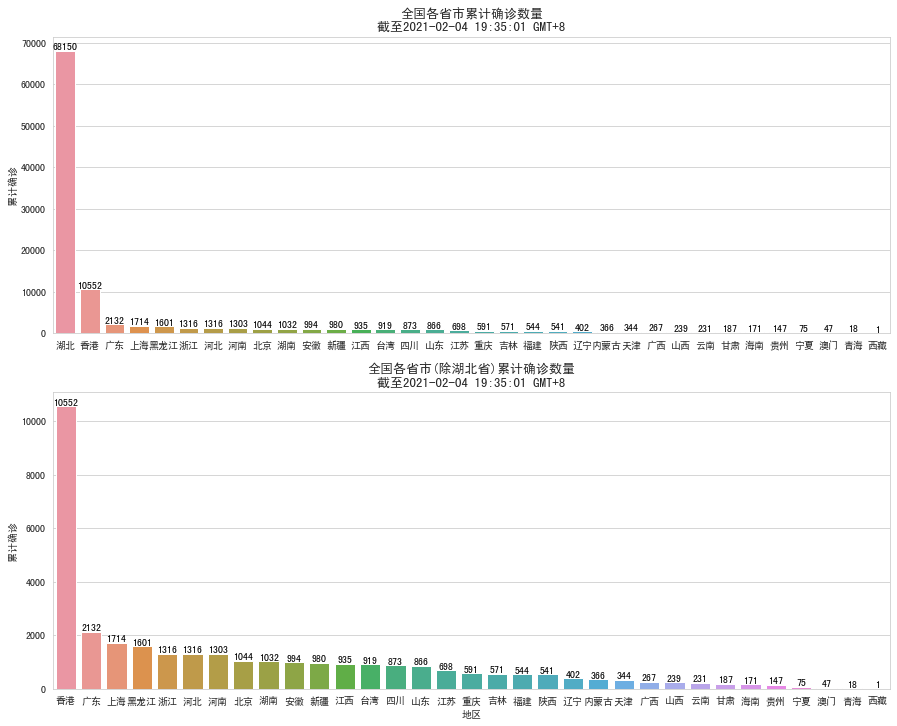

In [1112]:
sort_china2 = china_df_agg.sort_values(['confirm'],ascending=False).reset_index()
fig,ax = plt.subplots(2,1,figsize=(15,12))
sns.barplot(ax=ax[0],data=sort_china2,x='province',y='confirm')
ax[0].set_title('全国各省市累计确诊数量\n截至'+lastUpdateTime+' GMT+8',fontsize=13)
ax[0].set_xlabel('')
ax[0].set_ylabel('累计确诊')
sns.barplot(ax=ax[1],data=sort_china2.loc[sort_china2['province']!='湖北',:],x='province',y='confirm')
ax[1].set_title('全国各省市(除湖北省)累计确诊数量\n截至'+lastUpdateTime+' GMT+8',fontsize=13)
ax[1].set_xlabel('地区')
ax[1].set_ylabel('累计确诊')
for i in range(2):    
    for p in ax[i].patches:
            ax[i].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                        ha='center', va='bottom',color= 'black')

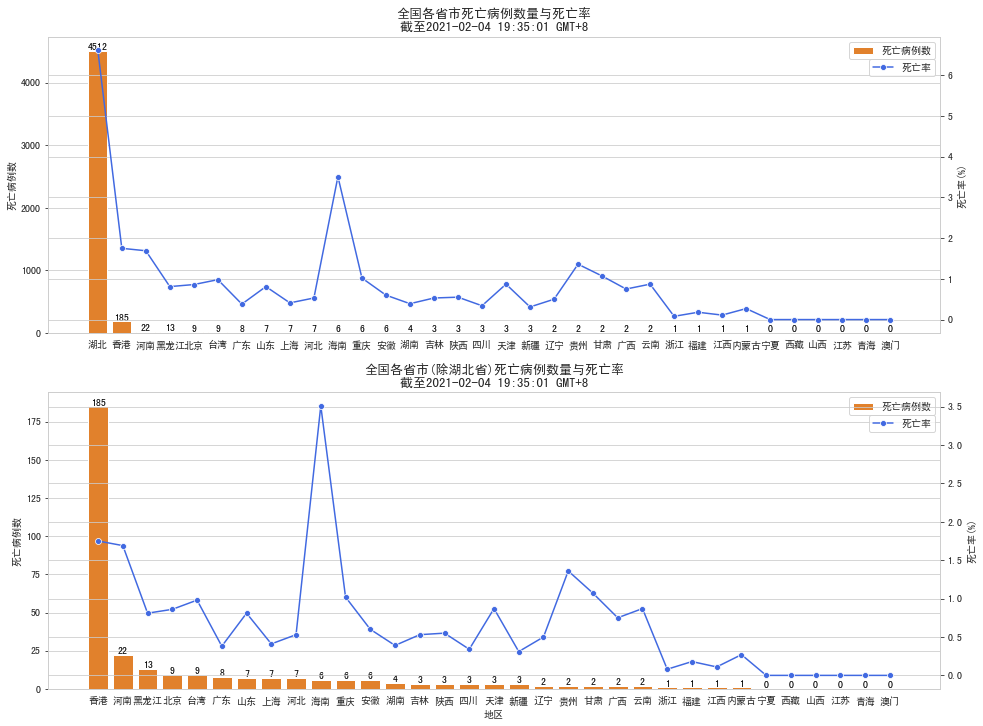

In [1114]:
sort_china3 = china_df_agg.sort_values(['dead'],ascending=False).reset_index()
fig,ax = plt.subplots(2,1,figsize=(16,12))

sns.barplot(ax=ax[0],data=sort_china3,x='province',y='dead',
            color='tab:orange',label='死亡病例数')
ax[0].set_title('全国各省市死亡病例数量与死亡率\n截至'+lastUpdateTime+' GMT+8',
                fontsize=13)
ax[0].set_xlabel('')
ax[0].set_ylabel('死亡病例数')
ax[0].legend()
subax1 = ax[0].twinx()
sns.lineplot(ax=subax1,data=sort_china3,x='province',y='deadRate',
             color='royalblue',marker='o',label='死亡率')
subax1.set_ylabel('死亡率(%)')
subax1.legend(loc='lower right',bbox_to_anchor=(1,0.85))

sns.barplot(ax=ax[1],data=sort_china3.loc[sort_china3['province']!='湖北',:],
            x='province',y='dead',color='tab:orange',label='死亡病例数')
ax[1].set_title('全国各省市(除湖北省)死亡病例数量与死亡率\n截至'+lastUpdateTime+' GMT+8',fontsize=13)
ax[1].set_xlabel('地区')
ax[1].set_ylabel('死亡病例数')
ax[1].legend()
subax2 = ax[1].twinx()
sns.lineplot(ax=subax2,data=sort_china3.loc[sort_china3['province']!='湖北',:],
             x='province',y='deadRate',color='royalblue',marker='o',label='死亡率')
subax2.set_ylabel('死亡率(%)')
subax2.legend(loc='lower right',bbox_to_anchor=(1,0.85))


for i in range(2):    
    for p in ax[i].patches:
            ax[i].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                        ha='center', va='bottom',color= 'black')

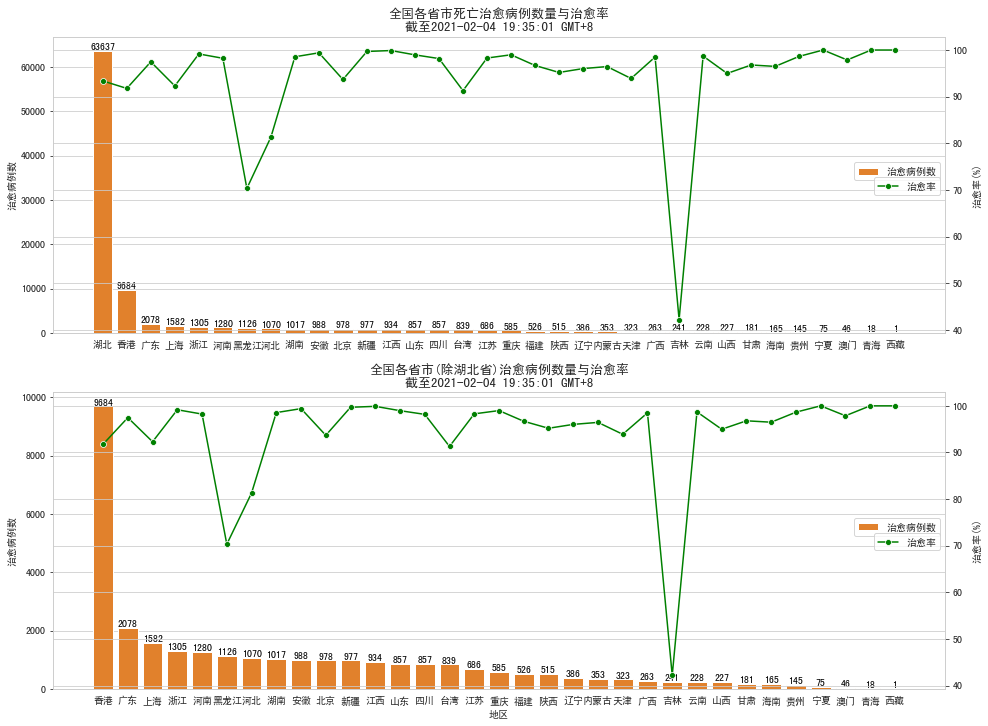

In [1115]:
sort_china4 = china_df_agg.sort_values(['heal'],ascending=False).reset_index()
fig,ax = plt.subplots(2,1,figsize=(16,12))

sns.barplot(ax=ax[0],data=sort_china4,x='province',y='heal',
            color='tab:orange',label='治愈病例数')
ax[0].set_title('全国各省市死亡治愈病例数量与治愈率\n截至'+lastUpdateTime+' GMT+8',
                fontsize=13)
ax[0].set_xlabel('')
ax[0].set_ylabel('治愈病例数')
ax[0].legend(loc='lower right',bbox_to_anchor=(1,0.5))
subax1 = ax[0].twinx()
sns.lineplot(ax=subax1,data=sort_china4,x='province',y='healRate',
             color='green',marker='o',label='治愈率')
subax1.set_ylabel('治愈率(%)')
subax1.legend(loc='lower right',bbox_to_anchor=(1,0.45))

sns.barplot(ax=ax[1],data=sort_china4.loc[sort_china4['province']!='湖北',:],
            x='province',y='heal',color='tab:orange',label='治愈病例数')
ax[1].set_title('全国各省市(除湖北省)治愈病例数量与治愈率\n截至'+lastUpdateTime+' GMT+8',fontsize=13)
ax[1].set_xlabel('地区')
ax[1].set_ylabel('治愈病例数')
ax[1].legend(loc='lower right',bbox_to_anchor=(1,0.5))
subax2 = ax[1].twinx()
sns.lineplot(ax=subax2,data=sort_china4.loc[sort_china4['province']!='湖北',:],
             x='province',y='healRate',color='green',marker='o',label='治愈率')
subax2.set_ylabel('治愈率(%)')
subax2.legend(loc='lower right',bbox_to_anchor=(1,0.45))

for i in range(2):    
    for p in ax[i].patches:
            ax[i].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                        ha='center', va='bottom',color= 'black')

In [1116]:
chinaCaseNow.sort_values(['riskLevel'])

,city/area,province,addConfirm,nowConfirm,riskLevel
2,长春,吉林,0,102,部分中风险
5,黄浦,上海,0,16,部分中风险
6,宝山,上海,0,4,部分中风险
0,通化,吉林,0,221,部分中高风险
1,哈尔滨,黑龙江,0,144,部分中高风险
3,石家庄,河北,0,214,部分中高风险
4,绥化,黑龙江,0,375,部分中高风险


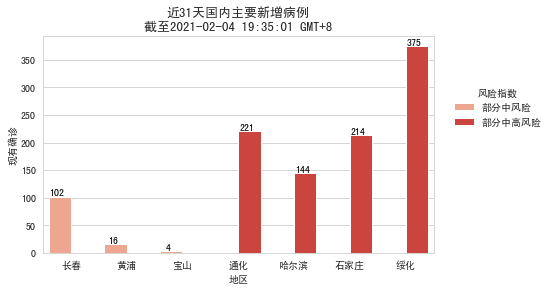

In [1117]:
caseNow = chinaCaseNow.sort_values(['riskLevel'])
caseNow.columns = ['地区','省','新增确诊','现有确诊','风险指数']
fig,ax = plt.subplots(figsize=(7,4))
#ax = sns.scatterplot(data=caseNow,x='地区',y='现有确诊',
                     #size='现有确诊',sizes=(60,400),hue='风险指数',palette='Reds')
ax = sns.barplot(data=caseNow,x='地区',y='现有确诊',hue='风险指数',palette='Reds')
ax.legend(frameon=False,bbox_to_anchor=(1.3,0.8),title='风险指数')
ax.set_title('近31天国内主要新增病例\n截至'+lastUpdateTime+' GMT+8',fontsize=13)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()),
                ha='center', va='bottom',color= 'black')

### 国外数据

In [1118]:
globalTotal = global_sum.iloc[range(1,len(global_sum)),[0]]
global_total_pie = Pie(init_opts=opts.InitOpts(width ='500px',height ='350px'))  #设置主题，和画布大小
global_total_pie.add('',[list(z) for z in zip(['累计确诊','治愈','死亡'], globalTotal['total'])],
            center=["50%", "50%"], #图的位置
            radius=[50, 80])   #内外径大小
global_total_pie.set_global_opts(title_opts=opts.TitleOpts(title="国外总量",
                                                           subtitle=("截至"+glastUpdateTime+' GMT+8')))
global_total_pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{c}"))  #标签格式
global_total_pie.render_notebook()

In [1119]:
globalAdd = global_sum.iloc[range(1,len(global_sum)),[1]]
totaladd_pie = Pie(init_opts=opts.InitOpts(width = '500px',height ='350px'))  #设置主题，和画布大小
totaladd_pie.add("",[list(z) for z in zip(['累计确诊','治愈','死亡'],globalAdd['addToday'])],
            center=["50%", "50%"],
            radius=[50, 80])
totaladd_pie.set_global_opts(
            title_opts=opts.TitleOpts(title="国外今日新增",subtitle=("截至"+lastUpdateTime+' GMT+8')))
totaladd_pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{c}"))  #标签格式
totaladd_pie.render_notebook()

In [1142]:
world_map = Map(init_opts=opts.InitOpts())
world_map.add("",[list(z) for z in zip(list(global_china_df["english"]), list(global_china_df["confirm"]))],
              "world",is_map_symbol_show=False)
world_map.set_global_opts(title_opts=opts.TitleOpts(title="世界累计确诊病例地图",subtitle=("截至"+glastUpdateTime+' GMT+8')),
                          visualmap_opts=opts.VisualMapOpts(is_piecewise=True,
                          pieces = [
                        {"min": 2500000 , "label": '>=2500000'},
                        {"min": 1000000, "max": 2499999, "label": '<2500000'},
                        {"min": 100000, "max": 999999, "label": '<1000000'},
                        {"min": 10000, "max": 99999, "label": '<100000'},
                        {"min": 0, "max": 9999, "label": '<10000' }]))
world_map.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
world_map.render_notebook()

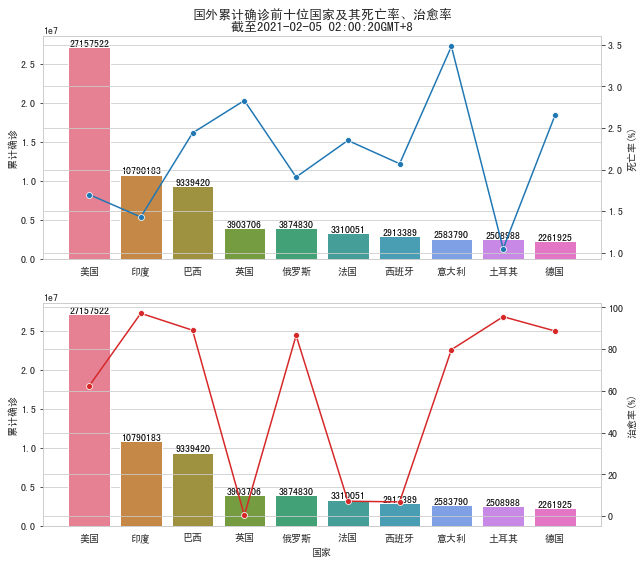

In [1122]:
confirm10 = global_df.sort_values(['confirm'],ascending=False).head(10)
fig,ax = plt.subplots(2,1,figsize=(10,9))
sns.barplot(ax=ax[0],data=confirm10,x='nation',y='confirm',palette='husl')
ax1=ax[0].twinx()
ax1 = sns.lineplot(data=confirm10,x='nation',y='deadRate',color='tab:blue',marker='o')
ax[0].set_xlabel('')
ax[0].set_ylabel('累计确诊')
ax1.set_ylabel('死亡率(%)')
ax[0].set_title('国外累计确诊前十位国家及其死亡率、治愈率\n截至'+glastUpdateTime+ 'GMT+8',fontsize=13)
sns.barplot(ax=ax[1],data=confirm10,x='nation',y='confirm',palette='husl')
ax2=ax[1].twinx()
ax2 = sns.lineplot(data=confirm10,x='nation',y='healRate',color='tab:red',marker='o')
ax[1].set_xlabel('国家')
ax[1].set_ylabel('累计确诊')
ax2.set_ylabel('治愈率(%)')
for i in range(2):    
    for p in ax[i].patches:
            ax[i].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                        ha='center', va='bottom',color= 'black')

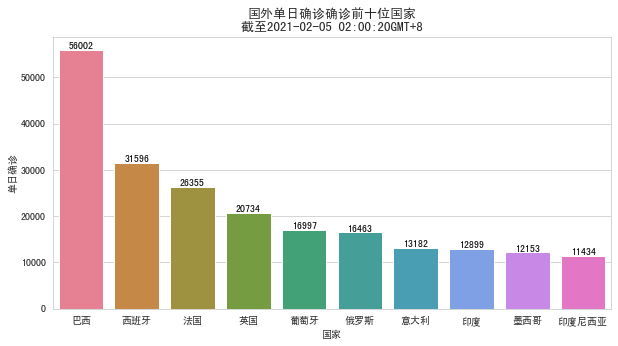

In [1123]:
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(data=addConfirmRank.head(10),x='nation',y='addConfirm',palette='husl')
ax.set_title('国外单日确诊确诊前十位国家\n截至'+glastUpdateTime+ 'GMT+8',fontsize=13)
ax.set_xlabel('国家')
ax.set_ylabel('单日确诊')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',color= 'black')

Text(0.5, 0, '日期')

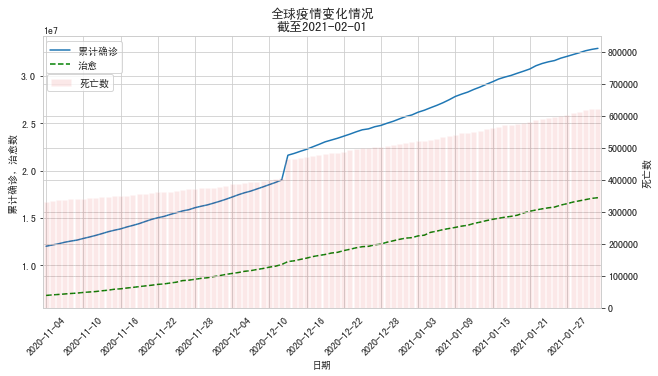

In [1124]:
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.lineplot(data=globalDaily,x='date',y='confirm',color='tab:blue',label='累计确诊')
ax = sns.lineplot(data=globalDaily,x='date',y='heal',color='green',linestyle='--',label='治愈')
ax.set_ylabel('累计确诊，治愈数')
ax1 = ax.twinx()
ax1 = sns.barplot(data=globalDaily,x='date',y='dead',color='red',alpha=0.1,label='死亡数')
ax1.set_ylabel('死亡数')
ax1.set_ylim(0,850000)
ax.legend(loc='upper right',bbox_to_anchor=(0.15,1))
ax1.legend(loc='upper right',bbox_to_anchor=(0.135,0.88))

ax.set_title('全球疫情变化情况\n截至'+list(globalDaily['date'])[-1],fontsize=13)
ax.xaxis.set_major_locator(plt.MaxNLocator(16))
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('日期')

Text(0.5, 1.0, '全球疫情死亡率、治愈率变化情况\n截至2021-02-01')

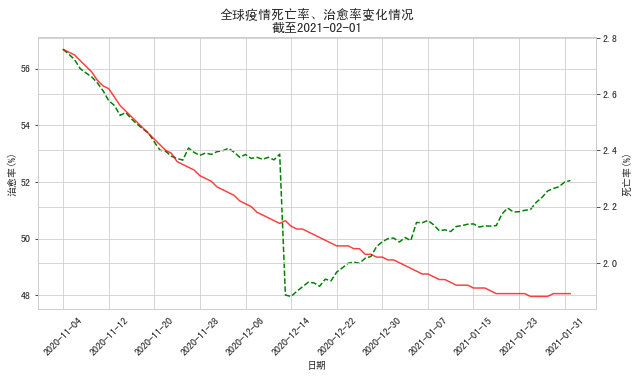

In [1152]:
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.lineplot(data=globalDaily,x='date',y='healRate',color='green',linestyle='--')
ax.xaxis.set_major_locator(plt.MaxNLocator(16))
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('日期')
ax.set_ylabel('治愈率(%)')
ax.set_title('全球疫情治愈率变化情况\n截至'+list(globalDaily['date'])[-1],fontsize=13)

ax1 = ax.twinx()
ax1 = sns.lineplot(data=globalDaily,x='date',y='deadRate',color='red',alpha=0.75)
ax.xaxis.set_major_locator(plt.MaxNLocator(16))
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('日期')
ax1.set_ylabel('死亡率(%)')
ax.set_title('全球疫情死亡率、治愈率变化情况\n截至'+list(globalDaily['date'])[-1],fontsize=13)

Text(0.5, 1.0, '全球疫情死亡率变化情况\n截至2021-02-01')

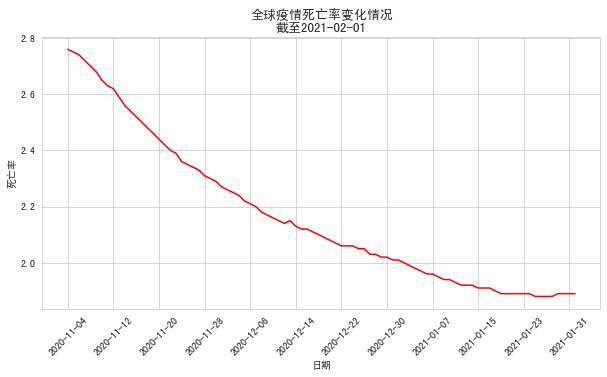

In [1126]:
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.lineplot(data=globalDaily,x='date',y='deadRate',color='red')
ax.xaxis.set_major_locator(plt.MaxNLocator(16))
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('日期')
ax.set_ylabel('死亡率')
ax.set_title('全球疫情死亡率变化情况\n截至'+list(globalDaily['date'])[-1],fontsize=13)

### 国内外对比

In [1127]:
global_china_df

,nation,english,confirm,dead,heal,addConfirm,deadRate,healRate
0,美国,United States,27157522,462075,16909844,6992,1.7,62.27
1,印度,India,10790183,154703,10480455,12899,1.43,97.13
2,巴西,Brazil,9339420,227563,8313044,56002,2.44,89.01
3,英国,United Kingdom,3903706,110462,10010,20734,2.83,0.26
4,俄罗斯,Russia,3874830,74005,3352720,16463,1.91,86.53
...,...,...,...,...,...,...,...,...
181,梵蒂冈,Vatican City,27,0,15,0,0,55.56
182,所罗门群岛,Solomon Islands,17,0,10,0,0,58.82
183,马绍尔群岛,Marshall Islands,4,0,4,0,0,100
184,瓦努阿图,Vanuatu,1,0,1,0,0,100


Text(0, 0.5, '治愈率(%)')

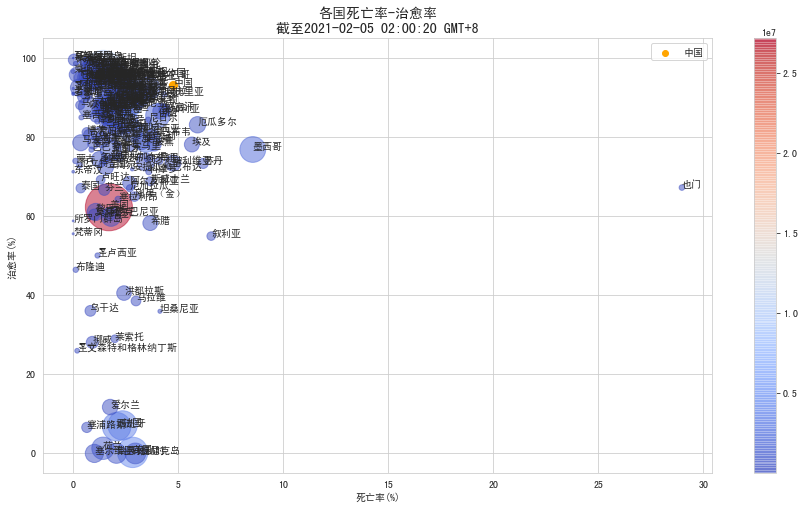

In [1130]:
fig,ax = plt.subplots(figsize=(15,8))
global_df.plot(ax=ax,kind='scatter',x='deadRate',y='healRate',c=global_df['confirm'],
                     s=global_df['confirm']**0.45,cmap='coolwarm',alpha=0.5,colorbar=True,legend=False)
ax = sns.scatterplot(data=global_china_df.loc[global_china_df['nation']=='中国',:],
                     x='deadRate',y='healRate',hue='nation',s=global_china_df['confirm'][185]**0.4,
                     palette=['orange'])
for i, point in global_china_df.iterrows():
    ax.text(point['deadRate'], point['healRate'],str(point['nation']))
ax.legend(title='')
ax.set_title('各国死亡率-治愈率\n截至'+glastUpdateTime+' GMT+8',fontsize=14)
ax.set_xlabel('死亡率(%)')
ax.set_ylabel('治愈率(%)')

Text(0, 0.5, '治愈率(%)')

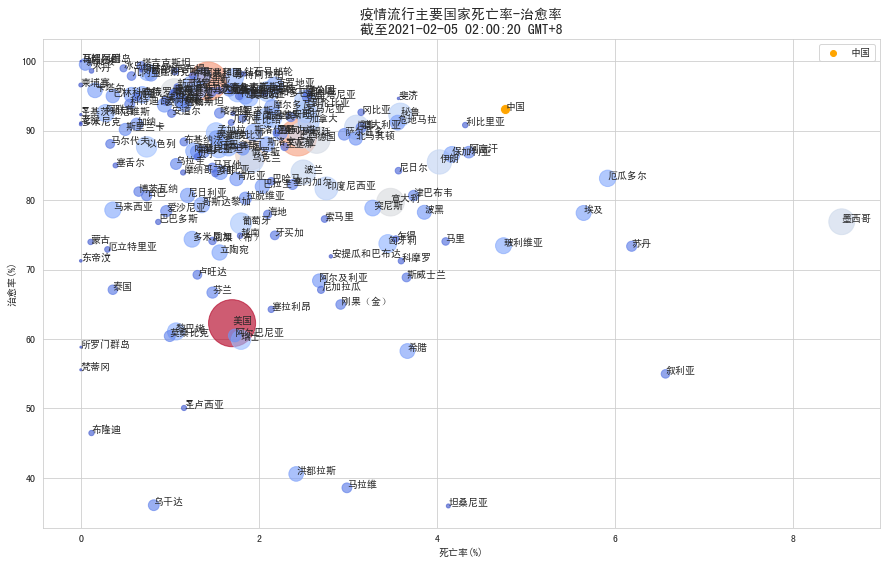

In [1131]:
global_df_adj = global_df.loc[(global_df['deadRate']<=10)&(global_df['healRate']>=30),:]
fig,ax = plt.subplots(figsize=(15,9))
global_df_adj.plot(ax=ax,kind='scatter',x='deadRate',y='healRate',c=global_df_adj['confirm']**0.3,
                     s=global_df_adj['confirm']**0.45,cmap='coolwarm',alpha=0.65,legend=False,colorbar=False)
ax = sns.scatterplot(data=global_china_df.loc[global_china_df['nation']=='中国',:],
                     x='deadRate',y='healRate',hue='nation',s=global_china_df['confirm'][185]**0.4,
                     palette=['orange'])
for i, point in global_df_adj.iterrows():
    ax.text(point['deadRate'], point['healRate'],str(point['nation']))
ax.text(global_china_df['deadRate'][185], global_china_df['healRate'][185],'中国')
ax.legend(title='')
ax.set_title('疫情流行主要国家死亡率-治愈率\n截至'+glastUpdateTime+' GMT+8',fontsize=14)
ax.set_xlabel('死亡率(%)')
ax.set_ylabel('治愈率(%)')